In [1]:
import torch
import torchvision
import os
import numpy as np
from pathlib import Path
from PIL import Image
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from src.res_model import ResNetUNet
import cv2
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import logging

# GPU 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  # Print the device being used

cuda:0


In [2]:
# 데이터셋 경로
data_dir = "input/segmented_chest_xray"
mask_dir = "input/segment_masks"
phases = ['train', 'val', 'test']

In [3]:
# 데이터 변환 정의
def data_transforms(phase):
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=3),
        transforms.ToTensor()
    ])
    return transform

# 마스크 불러오기 함수
def load_mask(mask_path):
    mask = Image.open(mask_path).convert("L")
    mask = transforms.functional.to_tensor(mask)
    mask = (mask > 0).float()
    return mask

# 사용자 정의 데이터셋 클래스
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, mask_dir, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.img_labels = []
        for phase in os.listdir(img_dir):
            phase_path = os.path.join(img_dir, phase)
            if not os.path.isdir(phase_path):
                continue
            for class_name in os.listdir(phase_path):
                class_path = os.path.join(phase_path, class_name)
                if not os.path.isdir(class_path):
                    continue
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    mask_path = img_path.replace(img_dir, mask_dir)
                    self.img_labels.append((img_path, mask_path, phase, class_name))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path, mask_path, phase, class_name = self.img_labels[idx]
        image = Image.open(img_path).convert("RGB")
        mask = load_mask(mask_path)

        if self.transform:
            image = self.transform(image)

        label = 0 if class_name == "NORMAL" else 1  # Assuming binary classification
        return image, mask, label

In [4]:
# 데이터셋 및 데이터로더 생성
batch_size = 8  # batch size를 늘림
num_workers = 4  # 적절한 num_workers 설정
pin_memory = True  # pin_memory 설정

image_datasets = {x: CustomImageDataset(data_dir, mask_dir, transform=data_transforms(x)) for x in phases}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=pin_memory) for x in phases}
dataset_sizes = {x: len(image_datasets[x]) for x in phases}
class_names = ["NORMAL", "PNEUMONIA"]

In [5]:
# 맞춤 손실 함수 정의
class MaskedCrossEntropyLoss(nn.Module):
    def __init__(self):
        super(MaskedCrossEntropyLoss, self).__init__()

    def forward(self, inputs, targets, masks):
        # Cross-entropy loss를 계산하고 마스크를 적용합니다
        loss = nn.functional.cross_entropy(inputs, targets, reduction='none')

        # masks를 outputs의 크기에 맞게 확장합니다
        masks = masks.squeeze(1)  # (batch_size, height, width)
        masks = masks.view(masks.size(0), -1).mean(dim=1)  # (batch_size,)
        loss = loss * masks

        return loss.mean()

# 맞춤 손실 함수 사용 예시
criterion = MaskedCrossEntropyLoss()


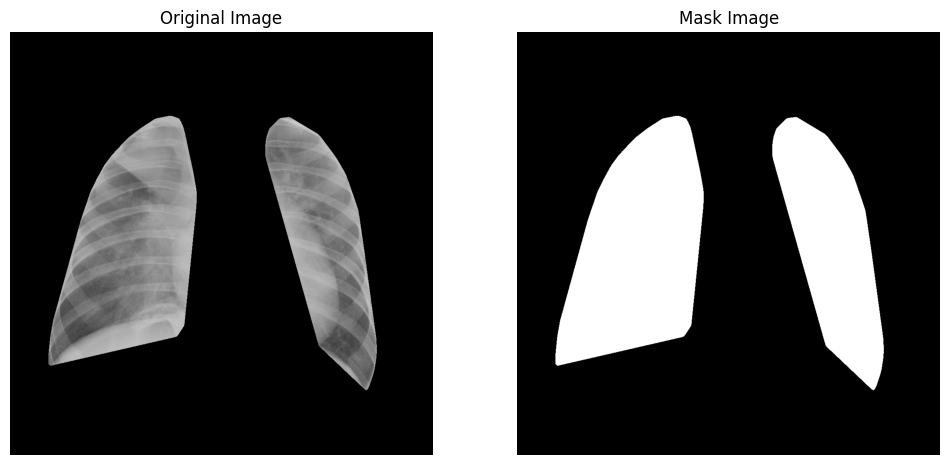

In [6]:
# 샘플 이미지 로드 및 시각화
inputs, masks, labels = next(iter(dataloaders['train']))
input_image = inputs[0]
mask = masks[0]
label = labels[0]

# 원본 이미지와 마스크 시각화
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(input_image.permute(1, 2, 0).numpy(), cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(mask.squeeze().cpu().numpy(), cmap='gray')
axes[1].set_title("Mask Image")
axes[1].axis("off")

plt.show()

In [7]:
# 학습 시 마스크 적용
def train_model_with_mask(model, criterion, optimizer, scheduler, num_epochs=60):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f"Epoch: {epoch+1}/{num_epochs}")
        print("="*10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, masks, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                masks = masks.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels, masks)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"Model saved at epoch {epoch+1} with val loss: {best_val_loss:.4f}")

        scheduler.step()

    print(f'Best val Loss: {best_val_loss:.4f}')

    model.load_state_dict(best_model_wts)
    best_model_save_path = os.path.join('models', 'best_pneumonia_model.pth')
    os.makedirs(os.path.dirname(best_model_save_path), exist_ok=True)
    torch.save(model.state_dict(), best_model_save_path)
    print(f'Best model saved to {best_model_save_path}')

    return model

In [8]:
# Load the Pretrained Model
model_pre = models.resnet152(pretrained=True)
model_pre.load_state_dict(torch.load("/content/진폐증copy/models/resnet152-394f9c45.pth"))
for param in model_pre.parameters():
    param.requires_grad = False

# ResNet152의 마지막 fully connected layer를 변경
num_features = model_pre.fc.in_features
model_pre.fc = nn.Linear(num_features, len(class_names))

/opt/anaconda3/envs/yolo/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/yolo/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# 모델, 손실 함수, 옵티마이저, 스케줄러 설정
model_pre = model_pre.to(device)
optimizer = optim.Adam(model_pre.fc.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0)

In [10]:
# Train Phase
model_pre = train_model_with_mask(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=60)

2024-08-03 12:52:45,641 - INFO - Epoch: 1/60
2024-08-03 12:52:45,641 - INFO - ==========


KeyboardInterrupt: 